In [616]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [617]:
class VAE(nn.Module):
    def __init__(self, input_dim_w1, input_dim_w2, hidden_dim=32):
        super(VAE, self).__init__()

        # Encoder
        self.encoder_nn1 = nn.Sequential(
            nn.BatchNorm1d(input_dim_w2),
            nn.Linear(input_dim_w2, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.encoder_nn2 = nn.Sequential(
            nn.BatchNorm1d(input_dim_w1 + hidden_dim),
            nn.Linear(input_dim_w1 + hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, hidden_dim)
        self.fc_logvar = nn.Linear(hidden_dim, hidden_dim)

        # Decoder
        self.decoder_nn3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, input_dim_w1),
            # nn.BatchNorm1d(input_dim_w1),
            # nn.ReLU(),
        )
        self.decoder_nn4 = nn.Sequential(
            nn.Linear(hidden_dim + input_dim_w1, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, input_dim_w2),
            # nn.Sigmoid(),
        )

    def encode(self, w1, w2):
        h1 = self.encoder_nn1(w2)
        h2 = self.encoder_nn2(torch.cat((w1, h1), dim=1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        weight1_hat = self.decoder_nn3(z)
        weight2_hat = self.decoder_nn4(torch.cat((z, weight1_hat), dim=1))
        return weight1_hat, weight2_hat

    def forward(self, w1, w2):
        mu, logvar = self.encode(w1, w2)
        z = self.reparameterize(mu, logvar)
        weight1_hat, weight2_hat = self.decode(z)
        return weight1_hat, weight2_hat, mu, logvar


def loss_function(weight1_hat, weight2_hat, weight1, weight2, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss1 = F.mse_loss(weight1_hat, weight1, reduction="sum")
    recon_loss2 = F.mse_loss(weight2_hat, weight2, reduction="sum")
    recon_loss = recon_loss1 + recon_loss2

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return recon_loss + kl_loss

In [618]:
import pickle
import io
from torch.utils.data import DataLoader, Dataset

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "torch.storage" and name == "_load_from_bytes":
            return lambda b: torch.load(io.BytesIO(b), map_location="cpu")
        else:
            return super().find_class(module, name)


with open('2_layer_real_models.pickle', 'rb') as f:
    real_models = CPU_Unpickler(f).load()

class WeightsDataset(Dataset):
    def __init__(self, state_dicts):
        self.data = [self.flatten_state_dict(sd) for sd in state_dicts]
        # self.mean_w1, self.std_w1, self.mean_w2, self.std_w2 = (
        #     self.calculate_statistics()
        # )
        # self.data = [
        #     (
        #         self.normalize(w1),
        #         self.normalize(w2),
        #     )
        #     for w1, w2 in self.data
        # ]
        self.data = self.global_normalize(self.data)

    def flatten_state_dict(self, state_dict):
        weight1 = state_dict["classifier.0.weight"].view(-1)
        bias1 = state_dict["classifier.0.bias"].view(-1)
        weight2 = state_dict["classifier.2.weight"].view(-1)
        bias2 = state_dict["classifier.2.bias"].view(-1)
        flattened_w1 = torch.cat([weight1, bias1])
        flattened_w2 = torch.cat([weight2, bias2])
        return flattened_w1, flattened_w2

    # def calculate_statistics(self):
    #     all_w1 = torch.stack([w1 for w1, _ in self.data])
    #     all_w2 = torch.stack([w2 for _, w2 in self.data])
    #     mean_w1, std_w1 = all_w1.mean(dim=0), all_w1.std(dim=0)
    #     mean_w2, std_w2 = all_w2.mean(dim=0), all_w2.std(dim=0)
    #     return mean_w1, std_w1, mean_w2, std_w2

    # def normalize(self, data):
    #     min, max = data.min(), data.max()
    #     data = (2 * (data - min)) / (max - min) -1
    #     mean, std = data.mean(), data.std()
    #     data = (data - mean) / std
    #     return data

    def global_normalize(self, data):
        all_w1 = torch.cat([w1 for w1, _ in self.data])
        all_w2 = torch.cat([w2 for _, w2 in self.data])
        all = torch.cat([all_w1, all_w2])
        min, max = all.min(), all.max()
        data = [(self.minmax(w1, min, max), self.minmax(w2, min, max)) for w1, w2 in self.data]
        mean, std = all.mean(), all.std()
        data = [
            (self.normalize(w1, mean, std), self.normalize(w2, mean, std))
            for w1, w2 in self.data
        ]
        return data
    def minmax(self, data, min, max):
        return (2 * (data - min)) / (max - min) - 1
    def normalize(self, data, mean, std):
        return (data - mean) / std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = WeightsDataset(real_models)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

sample = train_dataset[0]
w1_size, w2_size = sample[0].size()[0], sample[1].size()[0]

Epoch: 0, Loss: 44.6073
Epoch: 1, Loss: 38.9294
Epoch: 2, Loss: 36.7260
Epoch: 3, Loss: 35.6848
Epoch: 4, Loss: 34.4533
Epoch: 5, Loss: 33.8698
Epoch: 6, Loss: 33.4381
Epoch: 7, Loss: 33.6908
Epoch: 8, Loss: 32.7921
Epoch: 9, Loss: 31.8135
Epoch: 10, Loss: 31.0954
Epoch: 11, Loss: 31.0640
Epoch: 12, Loss: 30.9605
Epoch: 13, Loss: 30.8707
Epoch: 14, Loss: 30.3451
Epoch: 15, Loss: 30.1492
Epoch: 16, Loss: 30.0685
Epoch: 17, Loss: 30.3168
Epoch: 18, Loss: 29.9976
Epoch: 19, Loss: 30.6165
Epoch: 20, Loss: 30.2812
Epoch: 21, Loss: 30.5759
Epoch: 22, Loss: 29.9260
Epoch: 23, Loss: 30.1881
Epoch: 24, Loss: 29.8741
Epoch: 25, Loss: 29.3237
Epoch: 26, Loss: 29.4938
Epoch: 27, Loss: 29.5851
Epoch: 28, Loss: 28.8457
Epoch: 29, Loss: 29.4660
Epoch: 30, Loss: 28.6193
Epoch: 31, Loss: 29.3362
Epoch: 32, Loss: 30.2308
Epoch: 33, Loss: 29.2470
Epoch: 34, Loss: 29.4493
Epoch: 35, Loss: 29.2431
Epoch: 36, Loss: 28.5978
Epoch: 37, Loss: 29.1477
Epoch: 38, Loss: 28.7397
Epoch: 39, Loss: 28.3436
Epoch: 40,

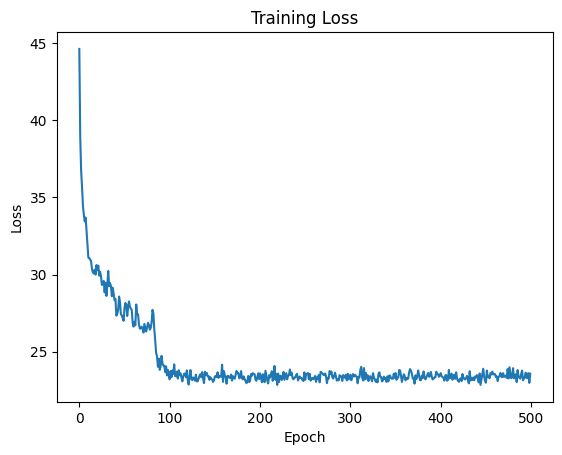

In [619]:
hidden_dim = 8
vae = VAE(input_dim_w1=w1_size, input_dim_w2=w2_size, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-1, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=10, verbose=True)

losses = []
epochs = 500
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for i, batch in enumerate(train_loader):
        batch_w1, batch_w2 = batch[0], batch[1]
        weight1_hat, weight2_hat, mu, logvar = vae(batch_w1, batch_w2)
        loss = loss_function(weight1_hat, weight2_hat, batch_w1, batch_w2, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    scheduler.step(avg_loss)
    print("Epoch: {}, Loss: {:.4f}".format(epoch, avg_loss))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [620]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train, device=device, dtype=torch.float32),
    torch.tensor(X_test, device=device, dtype=torch.float32),
    torch.tensor(y_train, device=device, dtype=torch.long),
    torch.tensor(y_test, device=device, dtype=torch.long),
)

0.84
0.82
0.94
0.72
0.7
0.82
0.98
0.8
0.84
0.72
0.82
0.96
0.88
0.82
0.8
0.8
0.78
0.68
0.84
0.66
0.98
0.98
0.82
0.78
0.9
0.72
0.98
0.82
0.8
0.9
0.74
0.7
0.7
0.8
0.94
0.74
0.98
0.76
0.86
0.86
0.72
0.88
0.88
0.78
0.96
0.88
0.98
0.74
0.86
0.86
0.98
0.96
0.94
0.96
0.9
0.86
0.84
0.9
0.74
0.92
0.94
0.78
0.8
0.42
0.98
0.84
0.88
0.46
0.84
0.84
0.9
0.7
0.96
0.92
0.82
0.78
0.88
0.84
0.9
0.8
0.86
0.98
0.8
0.8
0.98
0.8
0.82
0.86
0.98
0.74
0.92
0.88
0.84
0.78
0.96
0.9
0.68
0.82
0.98
0.84
0.7
0.78
0.86
0.9
0.84
0.88
0.92
0.8
0.74
0.78
0.84
0.72
0.48
0.84
0.98
0.8
0.82
0.74
0.7
0.96
0.98
0.86
0.76
0.68
0.78
0.94
0.96
0.7
0.74
0.84
0.98
0.92
0.78
0.98
0.8
0.58
0.94
0.62
0.7
0.74
0.84
0.96
0.96
0.8
0.92
0.68
0.82
0.98
0.88
0.82
0.82
0.94
0.62
0.92
0.7
0.84
0.82
0.9
0.98
0.72
0.88
0.88
0.98
0.82
0.94
0.68
0.98
0.7
0.82
0.68
0.76
0.94
0.88
0.7
0.98
0.98
0.8
0.76
0.82
0.98
0.98
0.98
0.76
0.8
0.94
0.98
0.96
0.76
0.88
0.88
0.88
0.86
0.94
0.98
0.72
0.76
0.74
0.76
0.98
0.82
0.7
0.88
0.82
0.94
0.8
0.82
0.94
0.9

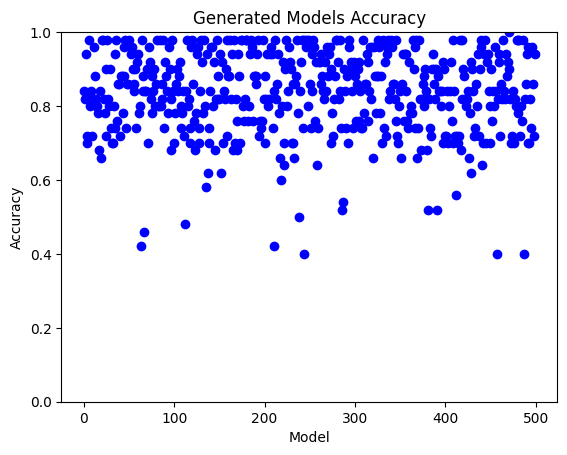

tensor(0.8344, dtype=torch.float64) tensor(0.1124, dtype=torch.float64)


In [621]:
from sklearn.metrics import accuracy_score
from model import Iris2LayerClassifier


NUM_OF_MODELS = 500

generated_tensors = []
with torch.no_grad():
    z = torch.randn(NUM_OF_MODELS, hidden_dim).to(device)
    vae.eval()
    weight1_hats, weight2_hats = vae.decode(z)

temp_model = Iris2LayerClassifier()
weight1_shape = temp_model.classifier[0].weight.shape
bias1_shape = temp_model.classifier[0].bias.shape
weight2_shape = temp_model.classifier[2].weight.shape
bias2_shape = temp_model.classifier[2].bias.shape
w1_len = torch.prod(torch.tensor(weight1_shape)).item()
w2_len = torch.prod(torch.tensor(weight2_shape)).item()
generated_models = []
for i in range(NUM_OF_MODELS):
    weight1_hat = weight1_hats[i]
    weight2_hat = weight2_hats[i]
    w1 = weight1_hat[:w1_len].view(weight1_shape)
    b1 = weight1_hat[w1_len:].view(bias1_shape)
    w2 = weight2_hat[:w2_len].view(weight2_shape)
    b2 = weight2_hat[w2_len:].view(bias2_shape)
    new_state_dict = {
        "classifier.0.weight": w1,
        "classifier.0.bias": b1,
        "classifier.2.weight": w2,
        "classifier.2.bias": b2,
    }
    generated_models.append(new_state_dict)

accuracies = []
for i, state_dict in enumerate(generated_models):
    model = Iris2LayerClassifier().to(device)
    model.load_state_dict(state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, labels = torch.max(y_pred, 1)
        accuracy = accuracy_score(y_test.cpu().numpy(), labels.cpu().numpy())
        accuracies.append(accuracy)
        print(accuracy)
        plt.scatter(i, accuracy, color='blue', marker='o')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim([0,1.0])
plt.title("Generated Models Accuracy")
plt.show()
print(torch.tensor(accuracies).mean(), torch.tensor(accuracies).std())

In [622]:
with open("2_layer_generated_models.pickle", "wb") as f:
    pickle.dump(generated_models, f)

In [623]:
torch.save(vae.state_dict(), "2_layer_vae.pt")